# Example segmentation with DeepLabv3+

In [1]:
import numpy as np
from glob import glob
import tensorflow as tf


In [2]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply
from tensorflow.keras.backend import max

In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")
#os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'


if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [
                tf.config.experimental.VirtualDeviceConfiguration(
                    memory_limit=1024 * 24
                )
            ],
        )
    except RuntimeError as e:
        print(e)


This example requires `swiss_army_keras` or higher:
```
pip3 install swiss_army_keras
```

In [4]:
#!pip3 install --upgrade git+https://github.com/waterviewsrl/swiss-army-keras.git
from swiss_army_keras import models, base, utils, quantization_utils, training_utils, dataset_utils

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-g1cfk7fj because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [5]:
# the indicator of a fresh run
first_time_running = False

# user-specified working directory 
filepath = './oxford_iiit/'

## The Oxford-IIIT Pets dataset

This example applies the dataset of [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) (Parkhi et al. 2012). This dataset contains images of pets and their pixel-wise mask that indicates (1) pixels belonging to the pet, (2) pixels bordering the pet, and (3) surrounding pixels.

The Oxford-IIIT Pets dataset will be downloaded and unpacked through the cell blow.

In [6]:
if first_time_running:
    # downloading and executing data files
    import tarfile
    import urllib.request
    
    filename_image = filepath+'images.tar.gz'
    filename_target = filepath+'annotations.tar.gz'
    
    urllib.request.urlretrieve('http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz', filename_image);
    urllib.request.urlretrieve('https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz', filename_target);
    
    with tarfile.open(filename_image, "r:gz") as tar_io:
        tar_io.extractall(path=filepath)
    with tarfile.open(filename_target, "r:gz") as tar_io:
        tar_io.extractall(path=filepath)
        
    os.system(f'cd {filepath} && cd images && rm *.mat && cd../../')

In [7]:
import albumentations as albu


In [8]:
from swiss_army_keras.dataset_utils import SegmentationAlbumentationsDataLoader
from weathermentations.rain import DropsOnLens

In [9]:
n_labels = 3

input_tensor = tf.keras.layers.Input((256, 256, 3), batch_size=1)

X_decoder = models.deeplab_v3_plus(input_tensor,
                                   n_labels=n_labels,
                                   backbone='EfficientNetLiteB0',
                                   atrous_rates=[],
                                   deep_layer=5,
                                   activation='ReLU',
                                   batch_norm=True,
                                   pool=True,
                                   unpool=True,
                                   name='Pets')



OUT_stack = X_decoder(input_tensor)
deeplabv3plus = keras.models.Model([input_tensor,], OUT_stack)
deeplabv3plus.preprocessing = X_decoder.preprocessing
deeplabv3plus.summary()

KerasTensor(type_spec=TensorSpec(shape=(1, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(1, 256, 256, 3)]        0         
_________________________________________________________________
model (Functional)           (1, 256, 256, 3)          4652771   
Total params: 4,652,771
Trainable params: 2,021,731
Non-trainable params: 2,631,040
_________________________________________________________________


In [10]:
def get_training_augmentation(width=513, height=513):
    train_transform = [
        

        #albu.RandomRotate90(p=0.5),
        
        #albu.OneOf([
        #   
        #   
        #], p=1),
        #albu.Resize(width, height, 2, p=1),

        #albu.ShiftScaleRotate(shift_limit = 0.05, scale_limit=(0.1, 0.1), interpolation=2, rotate_limit=25, p=0.3),
        
        albu.HorizontalFlip(p=0.5),
        #albu.VerticalFlip(p=0.15),

        albu.Compose([
        albu.OneOf([
            albu.ISONoise(p=1),
            albu.MultiplicativeNoise(p=1),
            albu.GaussNoise(p=1),
            albu.ImageCompression(p=1),

            ], 
            p=1,
        ),
        
        #albu.Perspective(pad_mode=2, p=0.1),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.Sharpen(p=1),
                albu.Emboss(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.5,
        ),

        albu.OneOf(
            [
                albu.Blur(blur_limit=5, p=1),
                albu.MedianBlur(blur_limit=5, p=1),
                albu.MotionBlur(blur_limit=5, p=1),
            ],
            p=0.25,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
                albu.RGBShift(p=1),
            ],
            p=0.25,
        ),
        
        albu.OneOf(
            [
                #albu.ElasticTransform(alpha=10, sigma=10 * 0.05, alpha_affine=10 * 0.03, p=0.5),
                albu.GridDistortion(p=0.5),
                albu.OpticalDistortion(distort_limit=0.3, shift_limit=0.05, p=1)      
            ],
            p=0.25,
        )], p=0.5),
        
        #DropsOnLens(maxR=40, minR=30, p=0.1),
        albu.ToGray(p=0.2)
    ]
    
    return albu.Compose(train_transform)
    #return albu.Compose([])


loader = SegmentationAlbumentationsDataLoader(num_classes=3,
                                              #precache=True,
                                              batch_size=16,
                                              width=256,
                                              height=256,
                                              dataset_path=filepath,
                                              masks_dir='annotations/trimaps',
                                              train_augmentations=get_training_augmentation(64, 64),
                                              label_shift=1,
                                              train_val_test_split=[0.8, 0.1, 0.1],
                                              normalization=deeplabv3plus.preprocessing,
                                              )


Train Images are good to go


In [11]:
train_set, val_set, test_set = loader.build_datasets()

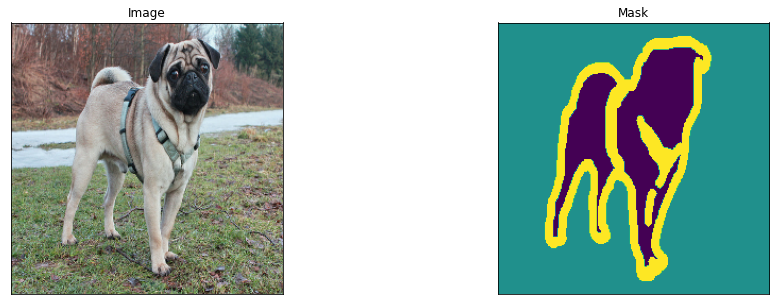

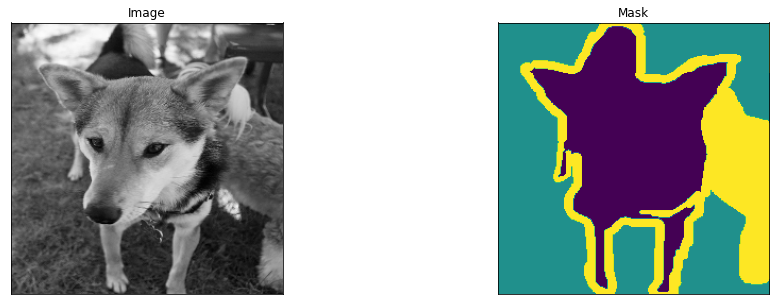

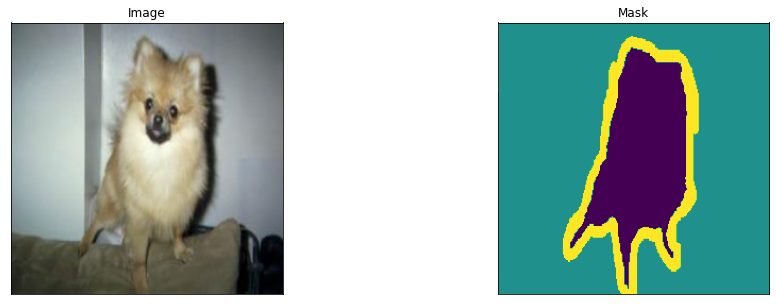

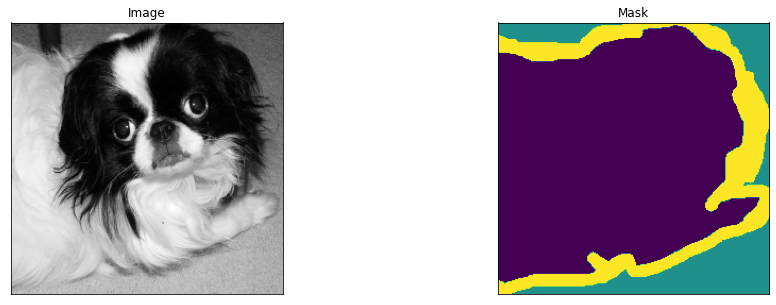

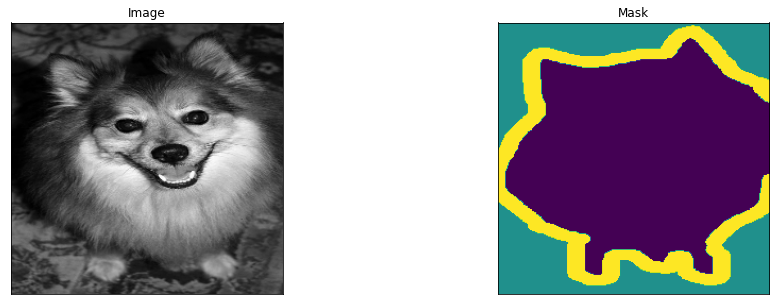

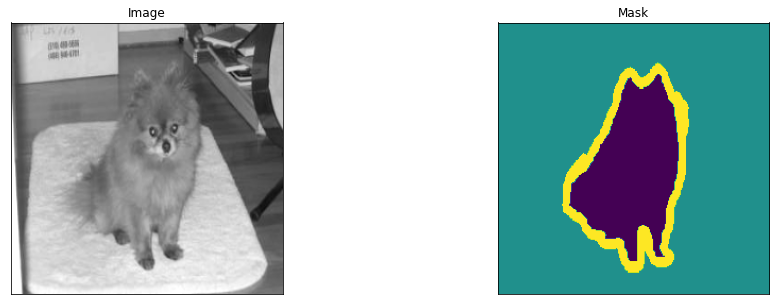

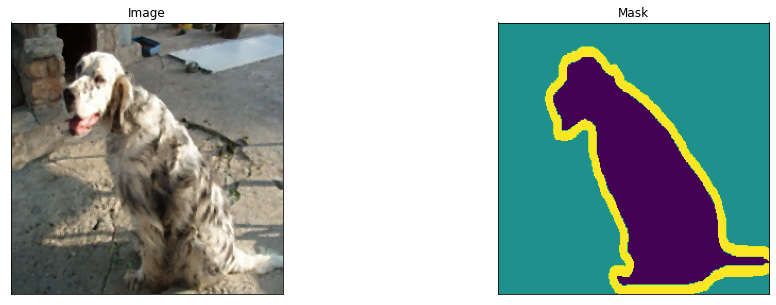

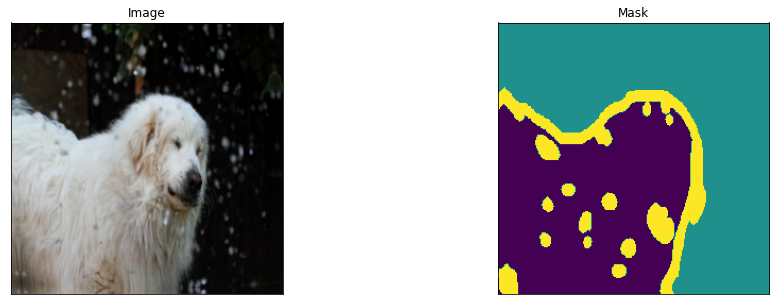

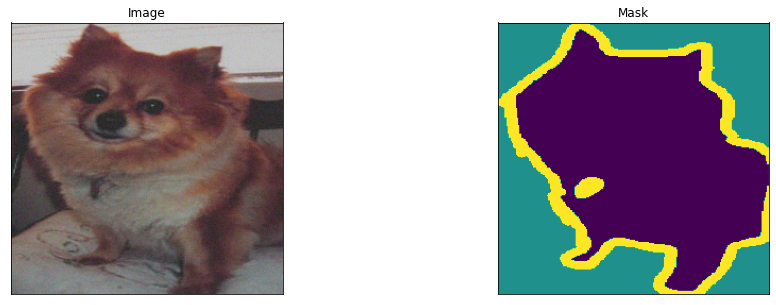

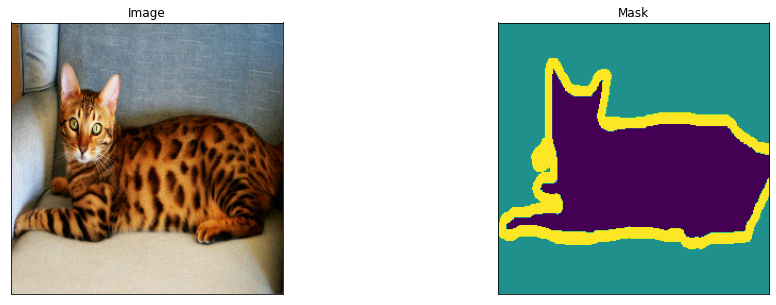

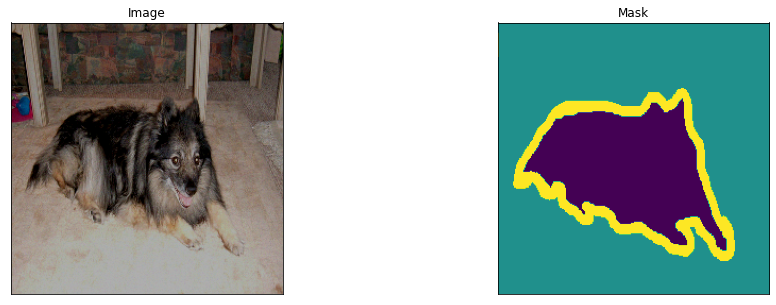

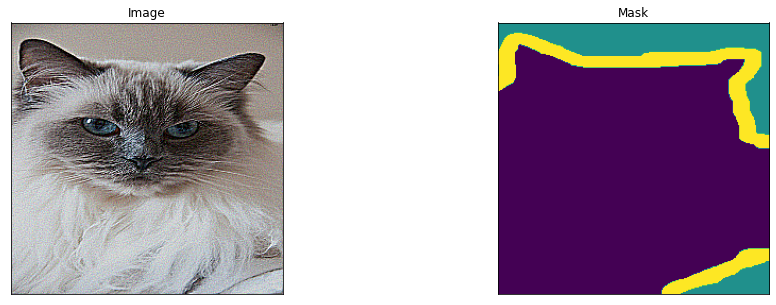

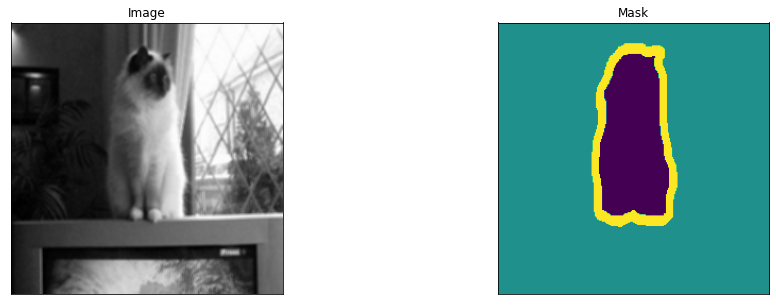

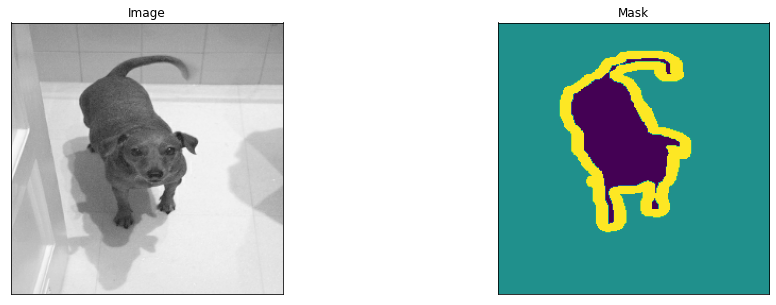

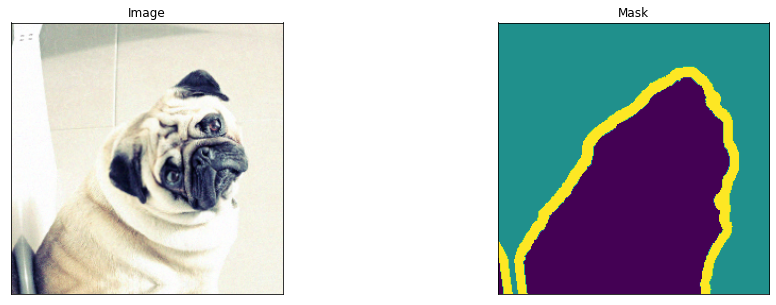

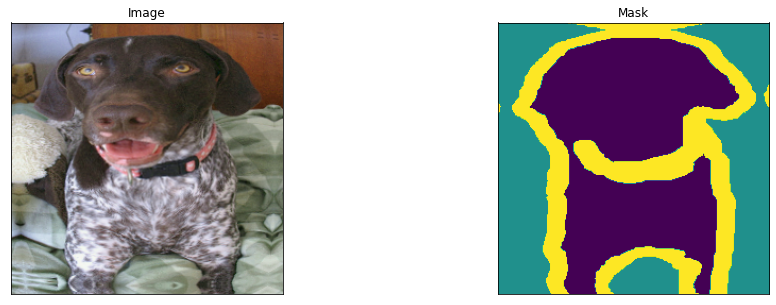

In [12]:
loader.show_images(dset='train', num_images=16)

In [13]:
from swiss_army_keras import losses, metrics

In [14]:
loss = losses.loss_adapter(losses.symmetrical_unified_focal_loss(), from_logits=True, label_smoothing=0.1)
accuracy = tf.keras.metrics.CategoricalAccuracy()
miou = metrics.MeanIOU(num_classes=n_labels)

In [15]:
from swiss_army_keras.training_utils import TrainingDriver
from adabelief_tf import AdaBeliefOptimizer

In [16]:
td = TrainingDriver(deeplabv3plus,'pets_model', AdaBeliefOptimizer(), loss, [accuracy, miou], train_set, val_set, test_set, 20 )

Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
>=0.1.0 (Current 0.2.1)  1e-14  supported          default: True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended epsilon = 1e-7                                  Recommended epsilon = 1e-14
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.



In [17]:
td.run()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(1, 256, 256, 3)]        0         
_________________________________________________________________
model (Functional)           (1, 256, 256, 3)          4652771   
Total params: 4,652,771
Trainable params: 2,021,731
Non-trainable params: 2,631,040
_________________________________________________________________
Epoch 1/20


/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


369/369 [==============================] - ETA: 0s - loss: 0.4020 - categorical_accuracy: 0.8556 - mean_iou: 0.6432WARNING:tensorflow:Model was constructed with shape (1, 256, 256, 3) for input KerasTensor(type_spec=TensorSpec(shape=(1, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (16, 256, 256, 3).


369/369 [==============================] - 34s 72ms/step - loss: 0.4020 - categorical_accuracy: 0.8556 - mean_iou: 0.6432 - val_loss: 0.3942 - val_categorical_accuracy: 0.8722 - val_mean_iou: 0.6910
Epoch 2/20
369/369 [==============================] - 25s 68ms/step - loss: 0.3573 - categorical_accuracy: 0.8992 - mean_iou: 0.7252 - val_loss: 0.3513 - val_categorical_accuracy: 0.9059 - val_mean_iou: 0.7555
Epoch 3/20
369/369 [==============================] - 25s 68ms/step - loss: 0.3472 - categorical_accuracy: 0.9085 - mean_iou: 0.7450 - val_loss: 0.3609 - val_categorical_accuracy: 0.8975 - val_mean_iou: 0.7307
Epoch 4/20
369/369 [==============================] - 25s 68ms/step - loss: 0.3427 - categorical_accuracy: 0.9128 - mean_iou: 0.7541 - val_loss: 0.3413 - val_categorical_accuracy: 0.9147 - val_mean_iou: 0.7666
Epoch 5/20
369/369 [==============================] - 25s 68ms/step - loss: 0.3392 - categorical_accuracy: 0.9159 - mean_iou: 0.7611 - val_loss: 0.3381 - val_categorical_a

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(1, 256, 256, 3)]        0         
_________________________________________________________________
model (Functional)           (1, 256, 256, 3)          4652771   
Total params: 4,652,771
Trainable params: 4,611,299
Non-trainable params: 41,472
_________________________________________________________________
Epoch 1/20


369/369 [==============================] - ETA: 0s - loss: 0.3725 - categorical_accuracy: 0.8885 - mean_iou: 0.7141WARNING:tensorflow:Model was constructed with shape (1, 256, 256, 3) for input KerasTensor(type_spec=TensorSpec(shape=(1, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (16, 256, 256, 3).


369/369 [==============================] - 79s 158ms/step - loss: 0.3725 - categorical_accuracy: 0.8885 - mean_iou: 0.7141 - val_loss: 0.3536 - val_categorical_accuracy: 0.9022 - val_mean_iou: 0.7398
Epoch 2/20
369/369 [==============================] - 54s 147ms/step - loss: 0.3466 - categorical_accuracy: 0.9086 - mean_iou: 0.7514 - val_loss: 0.3413 - val_categorical_accuracy: 0.9133 - val_mean_iou: 0.7657
Epoch 3/20
369/369 [==============================] - 54s 147ms/step - loss: 0.3382 - categorical_accuracy: 0.9162 - mean_iou: 0.7665 - val_loss: 0.3346 - val_categorical_accuracy: 0.9198 - val_mean_iou: 0.7775
Epoch 4/20
369/369 [==============================] - 55s 148ms/step - loss: 0.3327 - categorical_accuracy: 0.9211 - mean_iou: 0.7763 - val_loss: 0.3299 - val_categorical_accuracy: 0.9233 - val_mean_iou: 0.7848
Epoch 5/20
369/369 [==============================] - 54s 147ms/step - loss: 0.3298 - categorical_accuracy: 0.9237 - mean_iou: 0.7820 - val_loss: 0.3296 - val_categori

INFO:tensorflow:Assets written to: /tmp/tmpuq2_6gro/assets


INFO:tensorflow:Assets written to: /tmp/tmpuq2_6gro/assets
/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpobro38yf/assets


INFO:tensorflow:Assets written to: /tmp/tmpobro38yf/assets
/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


<Figure size 432x288 with 0 Axes>

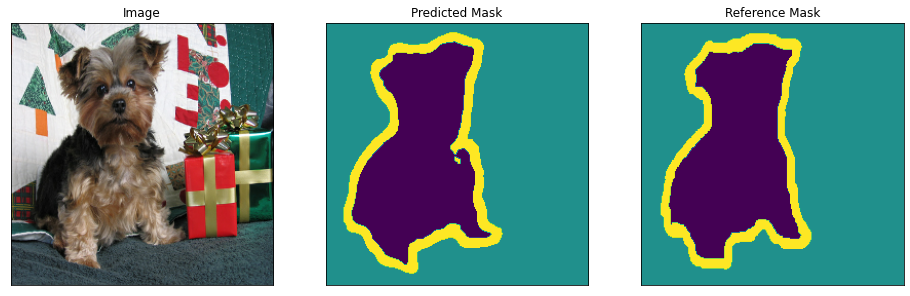

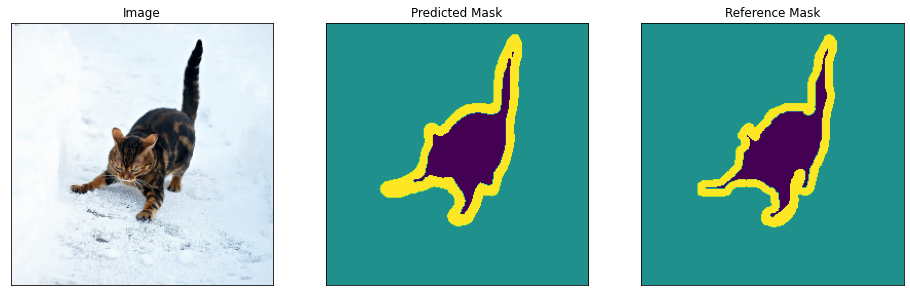

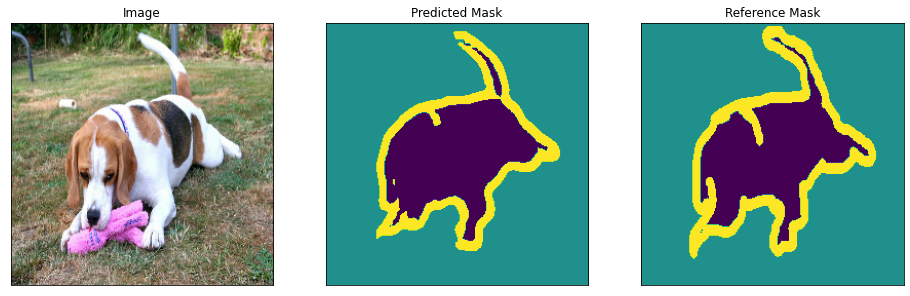

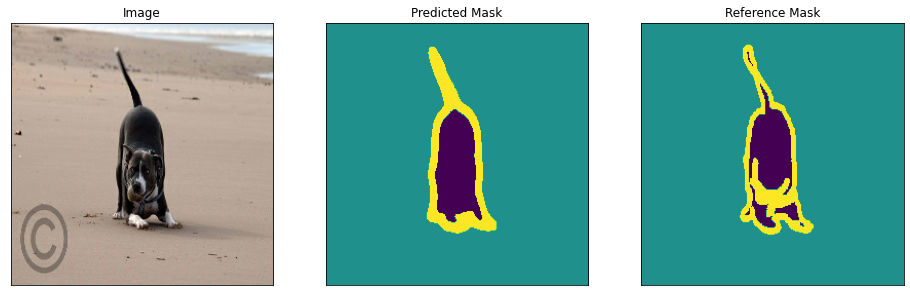

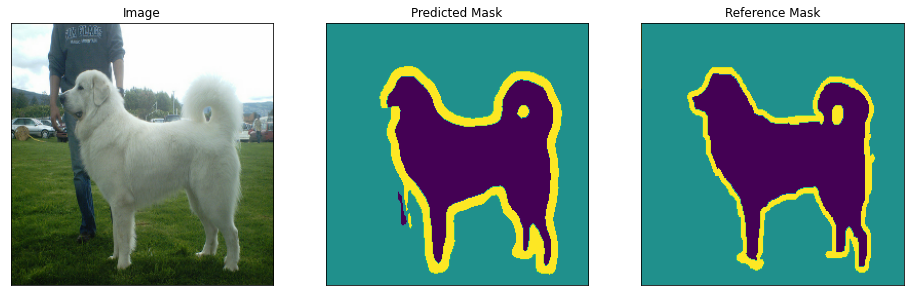

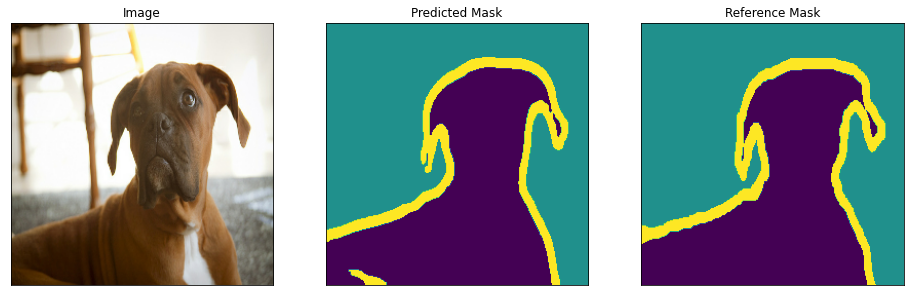

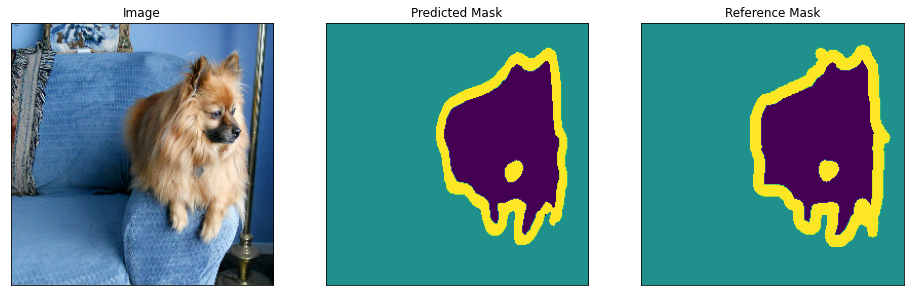

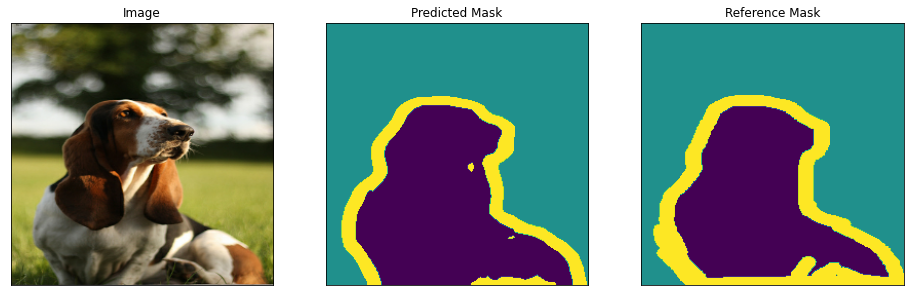

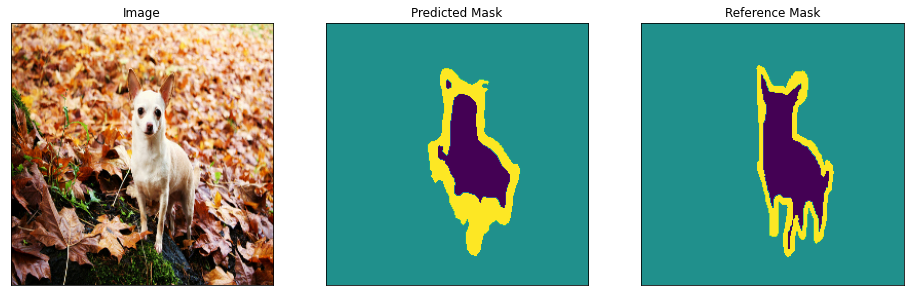

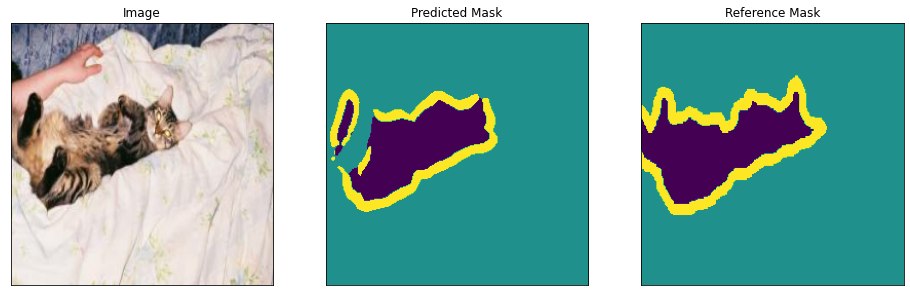

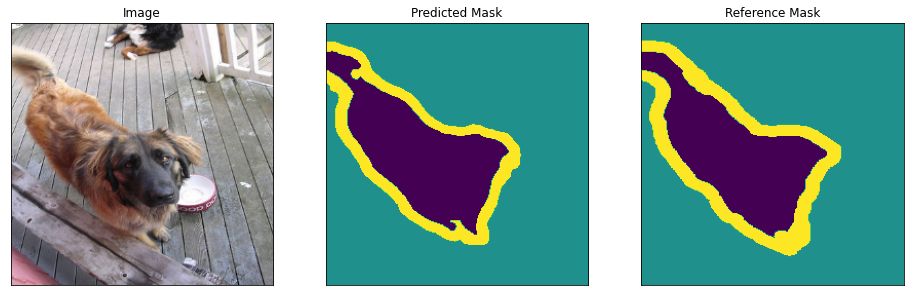

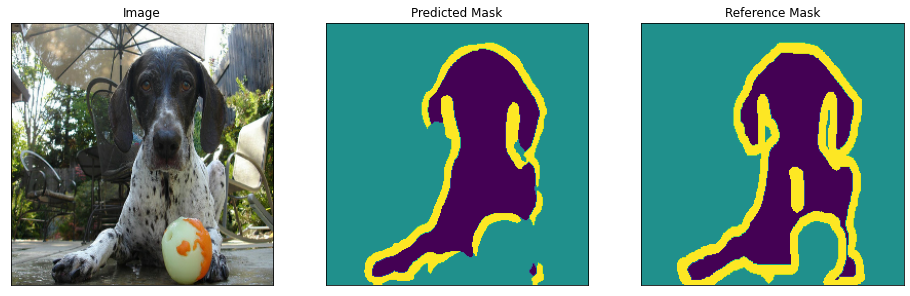

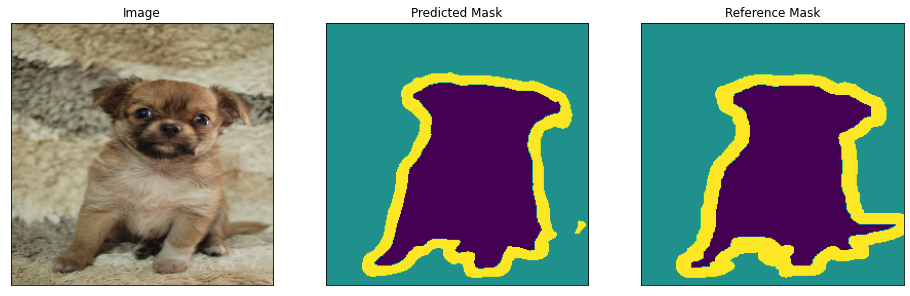

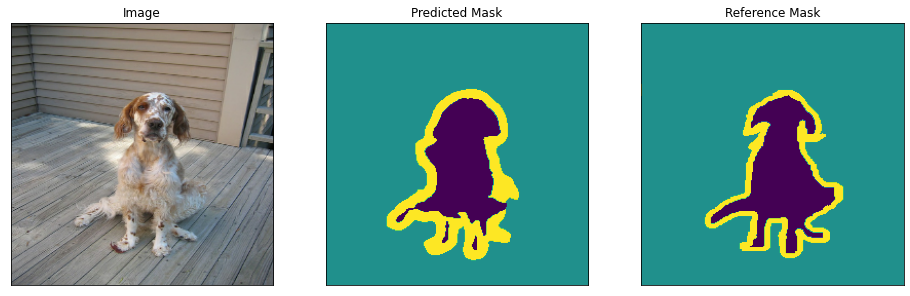

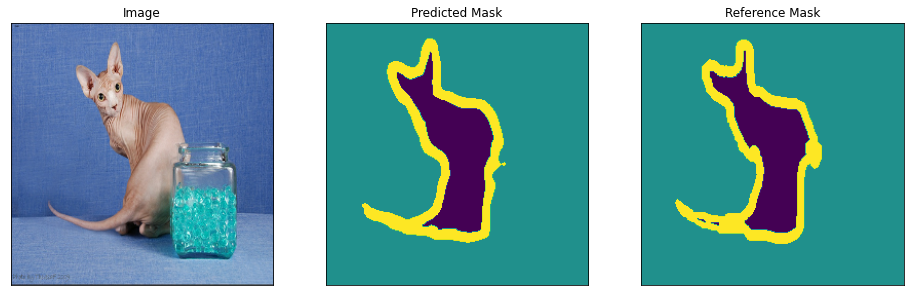

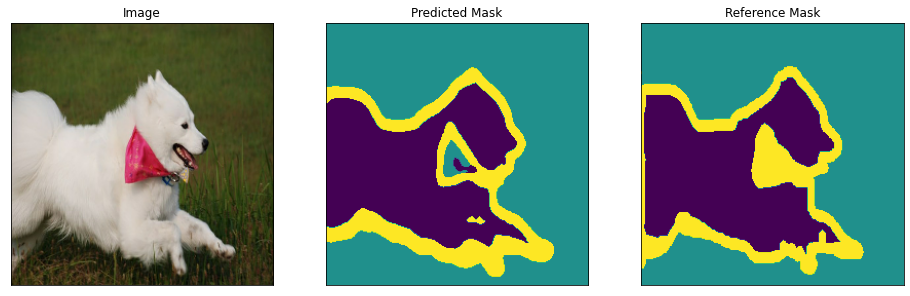

In [18]:
loader.show_results(deeplabv3plus, 16)